In [1]:
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import beam_propagation_method as bpm

# Initialize needed parameters (were already provided)

In [2]:
# computational parameters                                                         
z_end = 200       # propagation distance                                         
lam = 1         # wavelength                                                   
nd = 1.455     # reference index                                              
xa = 50        # size of computational window                                 
Nx = 1051# number of transverse points                                  
dx = xa/(Nx-1) # transverse step size                                         
                                                                                   
# waveguide parameters                                                             
xb = 2.0       # size of waveguide                                            
n_cladding = 1.45      # cladding index                                           
n_core = 1.46     # core refr. index                                             
                                                                                   
# source width                                                                     
w = 5.0       # Gaussian beam width                                          
                                                                                   
# propagation step size                                                            
dz = 0.5                                                                           
output_step = round(1.0/dz)                                                     
                                                                                   
# create index distribution                                                        
n, x = bpm.waveguide(xa, xb, Nx, n_cladding, n_core)                                   
                                                                                   
# create initial field                                                             
v_in, x = bpm.gauss(xa, Nx, w)                                                         

v_in = v_in/np.sqrt(np.sum(np.abs(v_in)**2)) # normalize power to unity 

a = timer()
v_out, z = bpm.beamprop_CN(v_in, lam, dx, n, nd, z_end, dz, 1)
b = timer()
print("Time elapsed double precision and factorized matrix \t\t{:.5f}s".format(b - a))


a = timer()
v_out_s, z = bpm.beamprop_CN(v_in, lam, dx, n, nd, z_end, dz, 1, method="solve")
b = timer()
print("Time elapsed double precision without prefactozired matrix \t{:.5f}s".format(b - a))

a = timer()
v_out_i, z = bpm.beamprop_CN(v_in, lam, dx, n, nd, z_end, dz, 1, method="invert")
b = timer()
print("Time elapsed double precision with inverted matrix \t\t{:.5f}s".format(b - a))

# for plotting
extent = (0, z_end, x[0], x[-1])

Time elapsed double precision and factorized matrix 		0.02729s
Time elapsed double precision without prefactozired matrix 	0.13287s
Time elapsed double precision with inverted matrix 		1.02322s


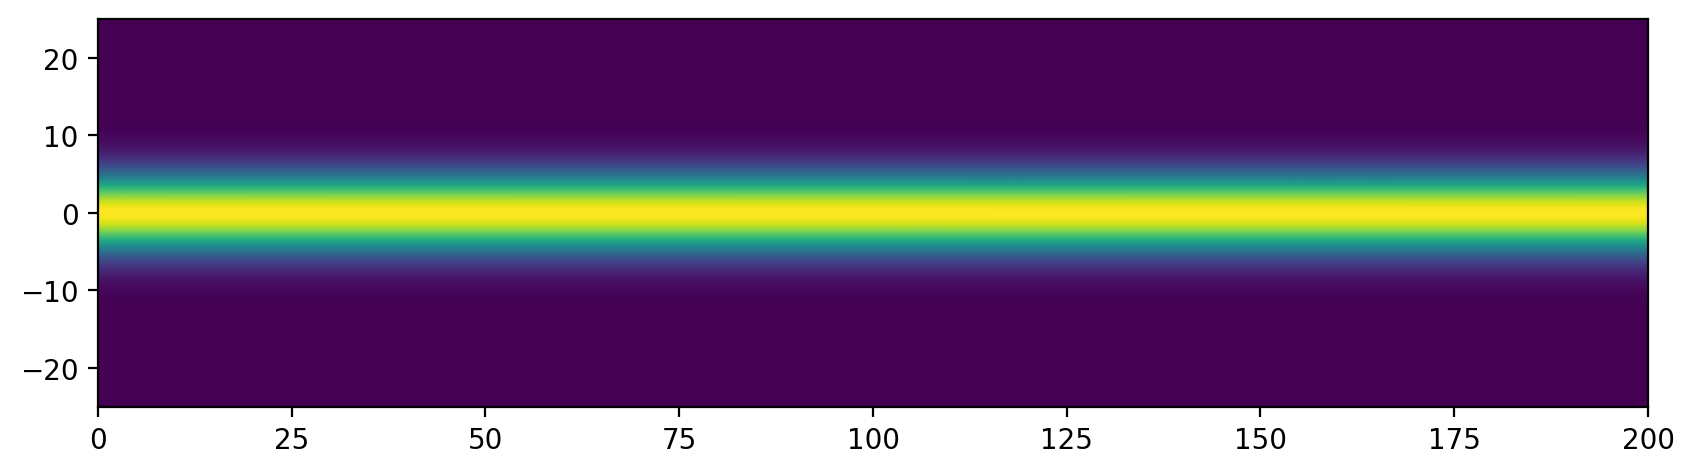

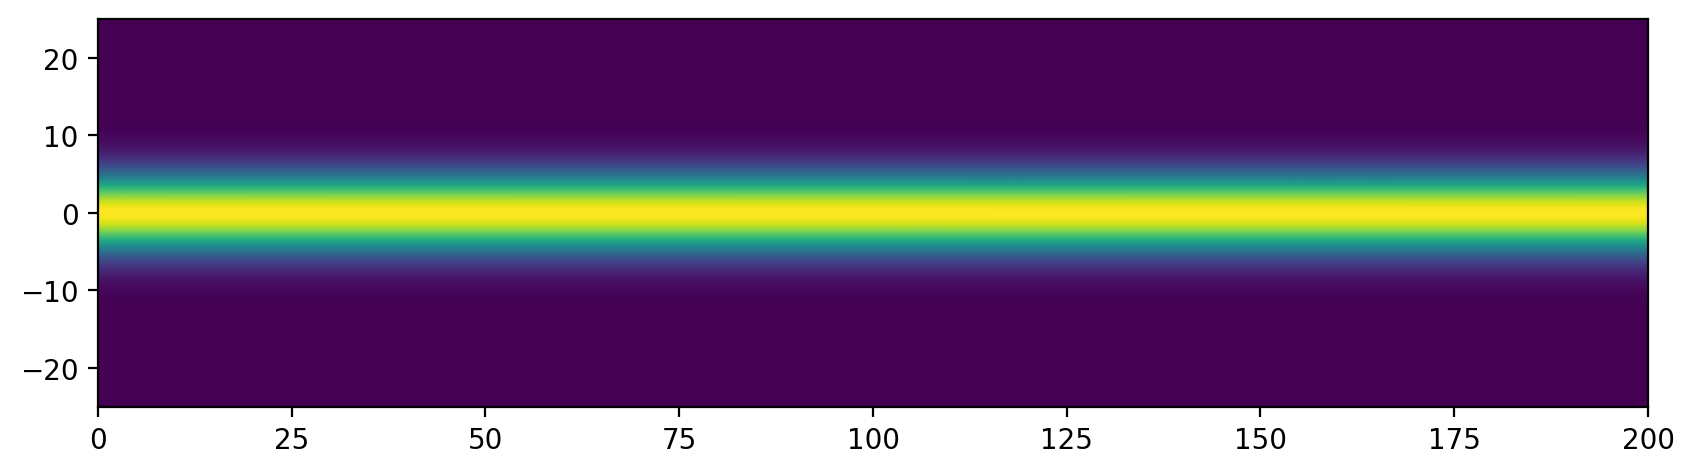

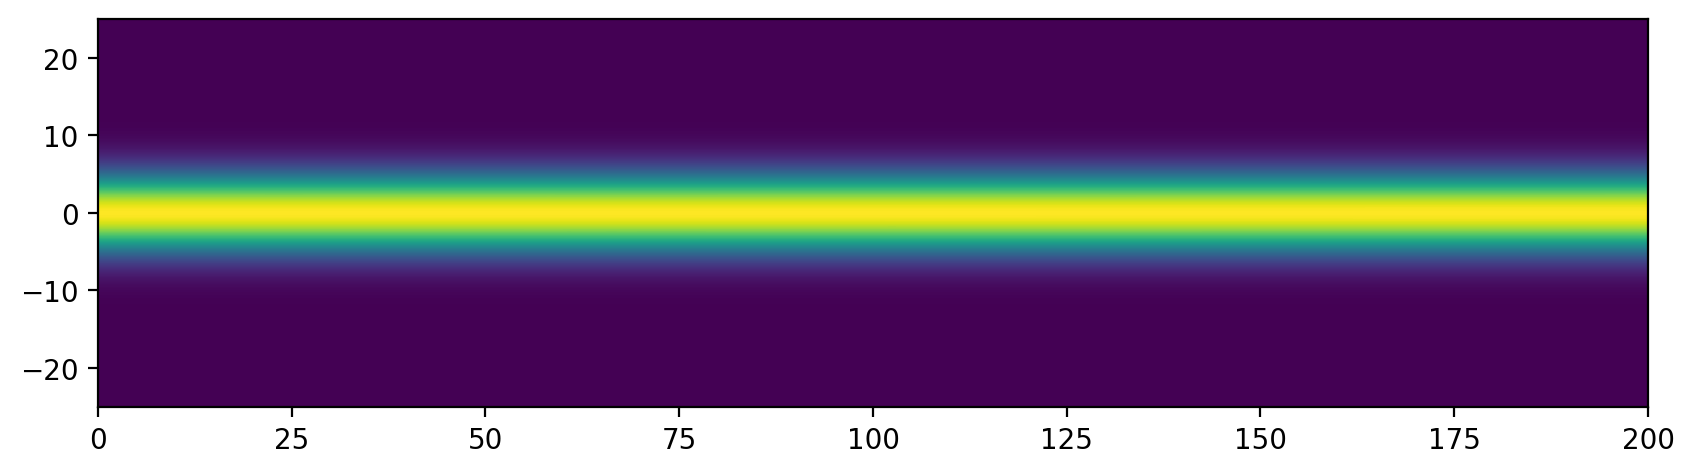

In [3]:
plt.figure(figsize=(10, 6), dpi=200, facecolor='w', edgecolor='k')
plt.imshow(np.transpose(np.abs(v_out)), extent=extent)

plt.figure(figsize=(10, 6), dpi=200, facecolor='w', edgecolor='k')
plt.imshow(np.transpose(np.abs(v_out_s)), extent=extent)

plt.figure(figsize=(10, 6), dpi=200, facecolor='w', edgecolor='k')
plt.imshow(np.transpose(np.abs(v_out_i)), extent=extent)

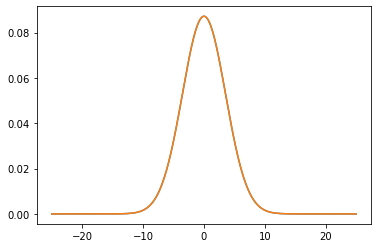

In [4]:
s = 1
plt.plot(x[s:-s], np.abs(v_out[0, s:-s]))
plt.plot(x[s:-s], np.abs(v_out[100, s:-s]))
#plt.plot(x[s:-s], np.abs(n[s:-s]))
#plt.plot(x[s:-s], v_in[s:-s])

In [5]:
v_out.shape

(400, 1051)

In [6]:
j = 100
print((np.abs(v_out[0, :]) - np.abs(v_out[j, :]))/(np.abs(v_out[0, :]) + np.abs(v_out[j, :])))
print(np.abs(v_out[0, :]))
print(np.abs(v_out[j, :]))

[-0.99999195 -0.99998915 -0.9999797  ... -0.9999013  -0.9999859
 -0.9999859 ]
[1.2106353e-12 1.3314820e-12 1.4641262e-12 ... 1.4641262e-12 1.3314820e-12
 1.2106353e-12]
[3.0452966e-07 2.4692838e-07 1.4399721e-07 ... 2.9656395e-08 1.8950288e-07
 1.7070775e-07]
